# Can a Trained Classification Model Be Improved Without Additional Variables?
In this tutorial we show how to use the `kxy` package to quantify the extent to which a trained classification model can be improved without resorting to new datasets. We show how the **improvability analysis** provided in the `kxy` package can help data scientist drastically reduce the number of unsuccesful experiments they run, thereby saving time and computing resources. Specifically, following [this classifiers benchmark from scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py), we train 10 different classifiers on 3 different synthetic datasets and we compare their out-of-sample performances. Then we show that, had we used the `kxy` improvability analysis, we would only have needed to train 2 out of the 10 models, which corresponds to an **80% cost reduction**.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

# Required imports
import pandas as pd
import seaborn as sns
import kxy

## Model Comparison

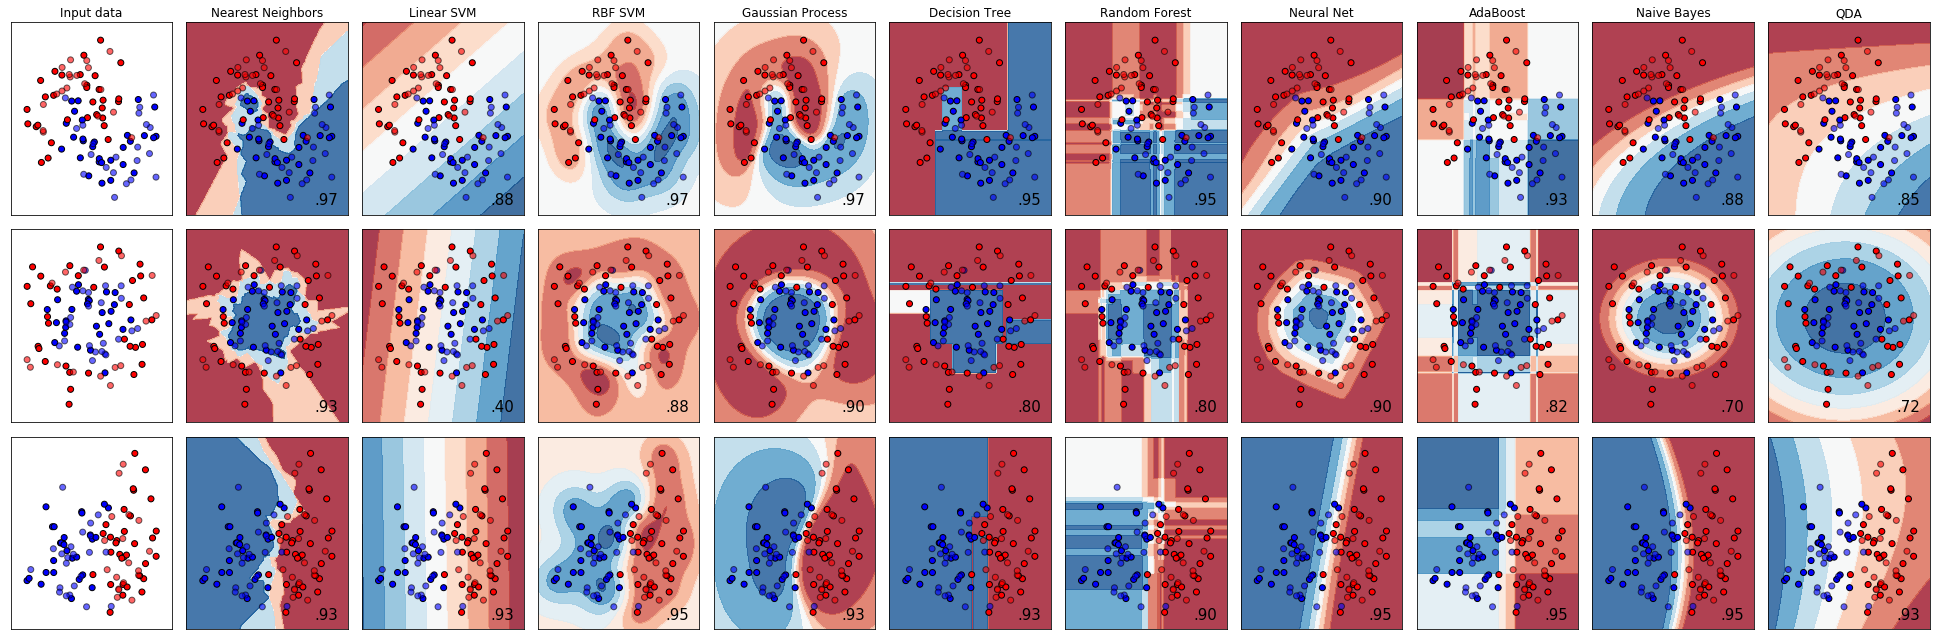

In [2]:
# The copyright mention below applies to this cell only.
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for scikit-learn documentation by Jaques Grobler
# Modified for the purpose of this tutorial by KXY Technologies, Inc.
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
dfs = []
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    df = pd.DataFrame({'x_0': X_test[:, 0], 'x_1': X_test[:, 1], 'y': y_test})
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        df[name + ' Prediction'] = clf.predict(X_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        
    dfs += [df.copy()]

plt.tight_layout()
plt.show()

## Improvability Analysis

We recall that our improvability analysis consists of taking the difference between the highest performance that could be achieved when predicting the label of interest $y$ with the variables/inputs at hand $x$, and the performance that has been achieved by a trained model $\mathcal{M}$ predicting that the label associated to specific inputs value $x$ is $y_p=f(x)$. This difference represents that value of $x$ for predicting $y$ that the trained model was unable to capture. 

Simply put, the aim of training a supervised learning model is to capture as much of the intrinsic value in variables $x$ for predicting the label $y$. The more value/performance was lost/leftover by a trained supervised learning model, the higher the chance that we could find another model, using the exact same variables $x$ to predict the same label $y$, that performs better.

When the performance leftover is very small on the other hand, no matter low the performance achieved by the trained model in an absolute sense, the trained model can hardly be improved using the same variables, and the data scientist looking for a performance boost should instead focus her efforts on gathering additional and complementary datasets to use as inputs.

### Lost Accuracy
We recall from the **theoretical foundation** part of the documentation that the highest classification accuracy that can be achieved by a trained classifier when $y$ has $q$ distrinct classes is 

$$\mathcal{\bar{A}}(x) = \bar{h}_q^{-1}\left(h(y)-I(y; x)\right),$$

where $\bar{h}_q(a) = -a\log a - (1-a)\log \left(\frac{1-a}{q-1} \right)$. Rather than evaluating the performance achieved empirically, we resort to estimating the best performance that can be achieved by predicting the label $y$ using the model prediction $y_p$ *as input*:

$$\mathcal{A}(y_p) = \bar{h}_q^{-1}\left(h(y)-I(y; y_p)\right).$$

In doing so, we estimate the value in $x$ for predicting $y$ that was permanently lost in the training process, in the sense that it cannot be recorvered from model predictions. This is very important because if a model is optimal (i.e. $\mathcal{A}(y_p) = \mathcal{\bar{A}}(x)$) but its *empirical* accuracy is different from $\mathcal{A}(y_p)$, then we know that there exists a deterministic label permutation of $y_p$ that is both optimal and has *empirical* accuracy $\mathcal{A}(y_p)$. 

As an illustration, let us consider a binary classification problem with achievable accuracy $\mathcal{\bar{A}}(x)=0.9$, and a model $\mathcal{M}$ with prediction $y_p=f(x), ~ y_p \in \{0, 1\},$ that is optimal (i.e. $\mathcal{A}(y_p)=0.9$). The model $\mathcal{M}^\prime$ with prediction $y^\prime_p = 1-y_p$ (i.e. obtained by a permutation of the labels predicted by $\mathcal{M}$) is also optimal (hint: Shannon entropy and mutual information only depend on probability masses, not on outcomes), and this is by design. 

Indeed, if $\mathcal{M}^\prime$ has empirical accuracy $0.1$ we should not go back to the drawing board and train new models, given that we know we could simply swap labels predicted by our trained model to obtain an accuracy of $0.9$. More generally, $\mathcal{A}(y_p)$ is invariant by deterministic label permutations, and any model deemed optimal by our improvability analysis is a deterministic label permutation away from having the highest empirical accuracy.

In summary, the `Lost Accuracy` column of our improvability analysis corresponds to the difference

$$\mathcal{\bar{A}}(x)-\mathcal{A}(y_p).$$

In [3]:
all_lost_accuracy = pd.DataFrame({
    name: [dfs[i].kxy.model_improvability_analysis(\
        'y', name + ' Prediction', input_columns=['x_0', 'x_1'])\
        .data['Lost Accuracy'][0] for i in range(3)] for name in names})
all_lost_accuracy['Dataset ==>'] = [0, 1, 2]
all_lost_accuracy.set_index(['Dataset ==>'], inplace=True)
cm = sns.light_palette("red", as_cmap=True)
all_lost_accuracy.T\
.style.background_gradient(cmap=cm)\
.set_caption("Tab 1: Amount of classification accuracy each model "\
             "missed out on.")

Dataset ==>,0,1,2
Nearest Neighbors,0,0,0.003
Linear SVM,0.033,0.43,0
RBF SVM,0,0.004,0
Gaussian Process,0,0,0.003
Decision Tree,0,0.119,0.004
Random Forest,0,0.125,0.037
Neural Net,0,0,0
AdaBoost,0,0.054,0
Naive Bayes,0.033,0.153,0
QDA,0.066,0.135,0


### Interpretation
Let us consider exploring our library of 10 classifiers from the simplest (resp. most explainable) model to the most complex model. 

We could train and compare all models in our library. However, we would incur a very high upfront cost,
as we would need to spend time implementing models or setting up experiments, wait for hours if not days to get experimental results when data abound, and use a lot of compute resources.

Our **improvability analysis empowers data scientists to proceed faster and cheaper**. We do not need to train all models upfront. Instead, we start with the simplest (resp. most explainable) model and we only train a new model if the additional performance our improvability analysis suggests we could achieve *outweighs* the disavantages in doing so (e.g. time, cost, and additional complexity/lack of interpretability).

If we apply this framework to our 3 toy datasets, we might want to start with the *linear SVM* classifier, as it is one of the simplest and most explainable of the 10 models. Our improvability analysis (second row in Table 2) suggests that it can be drastically improved for datasets 0 and 1, which is consistent with the fact that it is almost always the worst of all 10 models in our model comparison section above. Thus, it makes sense to keep trying for datasets 0 and 1. 

Our next iteration could be to try the *RBF SVM* classifier, if we are mostly concerned by model complexity, or the *Decision Tree* classifier if we care more about model explanability. If we choose to train the *RBF SVM* classifier (third row in Table 2), then our improvability analysis would suggest that we got very close to an optimal model, despite only training 2 models. If we choose instead to train the *Decision Tree* classifier (fifth row in Table 2), then our improvability analysis would suggest that we should keep trying to find a better model for dataset 1, but we could stop for dataset 0.

Although we used classification accuracy as performance metric, we could equally use the $R^2$ or the log-likelihood per sample; we would get the same conclusion.

### Lost $R^2$
We recall that in the **theoretical foundation** section, we extended the $R^2$ to classification models. The $R^2$ of a classification model predicting that the label associated to input variables $x$ is $y_p=f(x)$ reads $R^2\left(\mathcal{M}\right) := 1-e^{-2I(y; y_p)},$ and the highest value it can reach is the *achievable-$R^2$* $\bar{R}^2(x) := 1-e^{-2I(y; x)}.$

The `Lost R^2` column of our improvability analysis corresponds to the difference $\bar{R}^2(x)-R^2\left(\mathcal{M}\right).$

In [4]:
all_lost_r_squared = pd.DataFrame({
    name: [dfs[i].kxy.model_improvability_analysis(\
        'y', name + ' Prediction', input_columns=['x_0', 'x_1'])\
        .data['Lost R^2'][0] for i in range(3)] for name in names})
all_lost_r_squared['Dataset ==>'] = [0, 1, 2]
all_lost_r_squared.set_index(['Dataset ==>'], inplace=True)
all_lost_r_squared.round(3).T\
.style.background_gradient(cmap=cm)\
.set_caption(r'Tab 2: Amount of $R^2$ each model missed out on.')

Dataset ==>,0,1,2
Nearest Neighbors,0,0,0.006
Linear SVM,0.071,0.584,0
RBF SVM,0,0.008,0
Gaussian Process,0,0,0.006
Decision Tree,0,0.243,0.009
Random Forest,0,0.255,0.083
Neural Net,0,0,0
AdaBoost,0,0.113,0
Naive Bayes,0.071,0.307,0
QDA,0.141,0.274,0


### Lost Log-Likelihood Per Sample
The empirical log-likelihood of a supervised learning model $\mathcal{M}$ with model-based predictive distribution $q(y|x)$ reads $\sum_{i=1}^n \log q(y_i|x_i)$ where $(x_1, y_1), \dots, (x_n, y_n)$ are i.i.d. draws from the data-generating distribution. 

By the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), the empirical log-likelihood per sample $\frac{1}{n}\sum_{i=1}^n \log q(y_i|x_i)$ can be viewed as an approximation of the *true log-likelihood per sample* $$E\left(\log q(y|x) \right),$$
where the expectation is taken with respect to the *true* data generating distribution. 

By [Gibbs' inequality](https://en.wikipedia.org/wiki/Gibbs%27_inequality), $E\left(\log q(y|x) \right) \leq E\left(\log p(y|x) \right) := -h(y|x) = I(y; x)-h(y)$. 

In other words, the highest true log-likelihood per sample that can be achieved by a classification model using $x$ to predict $y$ is the *achievable true log-likelihood per sample* $$\mathcal{\bar{LL}}(x) := I(y; x)-h(y).$$

Similarly, the highest true log-likelihood per sample that be can achieved by predicting the value of $y$ associated to $x$ as, or using, $y_p=f(x)$ is

$$\mathcal{\bar{LL}}\left(\mathcal{M}\right) := I\left(y; y_p\right)-h(y).$$

The `Lost Log-Likelihood Per Sample` column of our improvability analysis corresponds to the difference $$\mathcal{\bar{LL}}(x)-\mathcal{\bar{LL}}\left(\mathcal{M}\right) = I(y; x)-I\left(y; y_p\right).$$


In [5]:
all_lost_r_squared = pd.DataFrame({
    name: [dfs[i].kxy.model_improvability_analysis(\
        'y', name + ' Prediction', input_columns=['x_0', 'x_1'])\
        .data['Lost Log-Likelihood Per Sample'][0] for i in range(3)] for name in names})
all_lost_r_squared['Dataset ==>'] = [0, 1, 2]
all_lost_r_squared.set_index(['Dataset ==>'], inplace=True)
all_lost_r_squared.round(3).T\
.style.background_gradient(cmap=cm)\
.set_caption('Tab 3: Amount of true log-likelihood per sample each model '\
             'missed out on.')

Dataset ==>,0,1,2
Nearest Neighbors,0,0,0.011
Linear SVM,0.083,0.439,0
RBF SVM,0,0.01,0
Gaussian Process,0,0,0.011
Decision Tree,0,0.23,0.015
Random Forest,0,0.239,0.122
Neural Net,0,0,0
AdaBoost,0,0.12,0
Naive Bayes,0.083,0.276,0
QDA,0.154,0.253,0
